## **FACIAL LANDMARKS DETECTION PROJECT**

#### IMPORTING ALL DEPENDENCIES

In [2]:
import os
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset,random_split
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from xml.etree import ElementTree as ET
import numpy as np
from torchvision import transforms
from skimage import io
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2


#### **CLASS FOR THE AUGMENTATION OF IMAGES**
----- **INCLUDED METHODS**
* OFFSET CROP
* RANDOM FACECROP
* RANDOM ROTATION


In [3]:
class FaceLandmarksAugmentation:
    def __init__(self, image_dim, brightness, contrast, saturation, hue, face_offset, crop_offset, rotation_limit):
        # Initialization parameters
        self.image_dim = image_dim            #Target dimension for the image.
        self.face_offset = face_offset        #Padding around the detected face during cropping.
        self.crop_offset = crop_offset        #Additional resizing offset.
        self.rotation_limit = rotation_limit  #Maximum rotation angle for random rotation.

        '''Initializes a color jitter transformation using transforms.ColorJitter to adjust the brightness, contrast,
        saturation, and hue of the image.'''

        self.transform = transforms.ColorJitter(brightness, contrast, saturation, hue)

    def offset_crop(self, image, landmarks, crops_coordinates):

        ''' This method crops the image based on given facial crop coordinates (crops_coordinates),
        modifies the facial landmarks accordingly, and resizes the image.'''


        '''Extracts the left, top, width, and height values from crops_coordinates,
        adding or subtracting face_offset to include padding around the face.'''

        left = int(crops_coordinates['left']) - self.face_offset
        top = int(crops_coordinates['top']) - self.face_offset
        width = int(crops_coordinates['width']) + (2 * self.face_offset)
        height = int(crops_coordinates['height']) + (2 * self.face_offset)

        image = TF.crop(image, top, left, height, width)
        landmarks = landmarks - np.array([[left, top]])  #making the landmarks relative to this new cropped image's coordinate system.

        # Adjusting the dimension of the cropped image
        new_dim = self.image_dim + self.crop_offset
        image = TF.resize(image, (new_dim, new_dim))

        # Scaling landmarks according to the new dimensions
        #This adjustment is necessary to maintain the correct placement of landmarks after the image has been resized from its original dimensions.
        landmarks[:, 0] *= new_dim / width
        landmarks[:, 1] *= new_dim / height

        return image, landmarks

    def random_face_crop(self, image, landmarks):
        # Converting the image to a NumPy array for manipulation
        image = np.array(image)

        # Get the height and width of the image
        h, w = image.shape[:2]

        # Randomly selecting the top-left corner for the crop,Ensuring the crop is within the limit
        top = np.random.randint(0, h - self.image_dim)
        left = np.random.randint(0, w - self.image_dim)

        # Cropping the image
        image = image[top: top + self.image_dim, left: left + self.image_dim]
        landmarks = landmarks - np.array([[left, top]])

        # Returning as PIL image and updated landmarks
        return TF.to_pil_image(image), landmarks

    def random_rotation(self, image, landmarks):
        # Generating a random rotation angle
        angle = np.random.uniform(-self.rotation_limit, self.rotation_limit)

        # Creating a rotation transformation matrix
        landmarks_transformation = np.array([
            [+np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
            [+np.sin(np.radians(angle)), +np.cos(np.radians(angle))]
        ])

        # Rotating the image by the generated angle
        image = TF.rotate(image, angle)

        # Transforming landmarks by the rotation matrix
        '''Assuming the landmark coordinates are normalized (i.e., they range from 0 to 1),
        subtracting 0.5 will change the coordinate system to be centered around (0.5, 0.5), which is the center of the image in normalized coordinates.'''

        landmarks = landmarks - 0.5  #This adjusts the landmarks by shifting them so that the origin (0, 0) is at the center of the coordinate system. This is done to apply the rotation around the center of the landmarks.
        transformed_landmarks = np.matmul(landmarks, landmarks_transformation)
        transformed_landmarks = transformed_landmarks + 0.5  # Re-centering after transformation

        return image, transformed_landmarks

    def __call__(self, image, landmarks, crops_coordinates):
        # Apply offset cropping first
        image, landmarks = self.offset_crop(image, landmarks, crops_coordinates)

        # Apply random cropping after offset cropping
        image, landmarks = self.random_face_crop(image, landmarks)

        # Apply random rotation on the cropped image and landmarks
        image, landmarks = self.random_rotation(image, landmarks)

        # Apply color jitter transformation
        return self.transform(image), landmarks

#### **PREPROCESSOR CLASS TO PREPROCESS ALL THE IMAGES IN THE DATASET USING DEFINED METHODS**

In [4]:
class Preprocessor:
    def __init__(self,
                 image_dim,
                 brightness,
                 contrast,
                 saturation,
                 hue,
                 rotation_limit,
                 face_offset,
                 crop_offset):

        self.image_dim = image_dim

        # Initialize the combined FaceLandmarksAugmentation class

        self.face_landmarks_augmentation = FaceLandmarksAugmentation(
            image_dim=image_dim,
            brightness=brightness,
            contrast=contrast,
            saturation=saturation,
            hue=hue,
            face_offset=face_offset,
            crop_offset=crop_offset,
            rotation_limit=rotation_limit
        )

    def __call__(self, image, landmarks, crops_coordinates):
        # Convert image to PIL if it's in NumPy format
        image = TF.to_pil_image(image)

        # Perform the full augmentation (face cropping, random cropping, random rotation, color jitter)
        image, landmarks = self.face_landmarks_augmentation.offset_crop(image, landmarks, crops_coordinates)
        image, landmarks = self.face_landmarks_augmentation.random_face_crop(image, landmarks)


        # Normalize landmarks by the image size (scaling them to be relative to the image dimensions)
        landmarks = landmarks / np.array([*image.size])
        image, landmarks = self.face_landmarks_augmentation.random_rotation(image, landmarks)

        # Convert the image to grayscale
        image = TF.to_grayscale(image)

        # Convert the image to a tensor
        image = TF.to_tensor(image)

        # Normalize the image to the range [-1, 1]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
        image = (2 * image) - 1  # Scale to [-1, 1],This is a common practice in deep learning to center the data around zero and improve model performance.


        return image, torch.FloatTensor(landmarks.reshape(-1) - 0.5)   #shifts the coordinates to be centered around zero. This adjustment ensures that landmarks are in the range [-0.5, 0.5], which can help with model convergence.


#### **CREATING THE DATASET CLASS FOR LOADING ALL DATA AND SIMULTANEOUSLY PREPROCESSING THEM**

In [5]:
class datasetlandmark(Dataset):
  def __init__(self,Preprocessor,train):
     self.rootdir= r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\Facial_Landmark_Detection_project\archive (1)\ibug_300W_large_face_landmark_dataset'
     self.imagepath=[]
     self.landmarks=[]
     self.crops_coordinates=[]
     self.preprocessor=Preprocessor
     self.train=train

     '''Parsing the xml tree to extract the data from the dataset'''

     tree=ET.parse(os.path.join(self.rootdir,f'labels_ibug_300W_{"train" if train else "test"}.xml'))
     root=tree.getroot()
     for child in root[2]:
       self.imagepath.append(os.path.join(self.rootdir,child.attrib['file']))
       self.crops_coordinates.append(child[0].attrib)
       landmark=[]
       for i in range(68):
          x_coordinate=int(child[0][i].attrib['x'])
          y_coordinate=int(child[0][i].attrib['y'])
          landmark.append([x_coordinate,y_coordinate])
       self.landmarks.append(landmark)
     self.landmarks=np.array(self.landmarks).astype('float32')

  def __len__(self):
    return len(self.imagepath)

  def __getitem__(self,index):
    image=io.imread(self.imagepath[index],as_gray=False)
    landmarks=self.landmarks[index]
    crops_coordinates=self.crops_coordinates[index]

    image,landmarks=self.preprocessor(image,landmarks,crops_coordinates)

    return image,landmarks

##### **FUNCTION TO SHOW THE IMAGE**

In [6]:
def imageshowing(image,landmarks):
  plt.figure(figsize=(5,5))
  image=(image-image.min())/(image.max()-image.min())  #Normalizes the image to have pixel values in the range [0, 1].
  landmarks=landmarks.view(-1,2)
  landmarks =(landmarks+0.5)*preprocessor.image_dim  #The landmarks were previously normalized to be in the range [-0.5, 0.5] in the preprocessing step. Adding 0.5 brings them to the range [0, 1].
  plt.imshow(image[0],cmap='gray')
  plt.scatter(landmarks[:,0],landmarks[:,1],s=20,c='dodgerblue')  #Plots the landmarks on top of the image using plt.scatter().
  plt.axis('off')
  plt.show()

#### **GETTING THE DATA**

In [7]:
preprocessor=Preprocessor(
                 image_dim=128,
                 brightness=0.24,
                 contrast=0.15,
                 saturation=0.3,
                 hue=0.1,
                 rotation_limit=14,
                 face_offset=32,
                 crop_offset=16)
trainimages=datasetlandmark(preprocessor,train=True)
testimages=datasetlandmark(preprocessor,train=False)

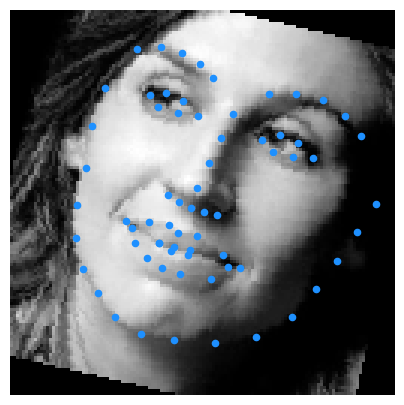

In [8]:
image1,landmarks1=trainimages[190]
imageshowing(image1,landmarks1)

In [9]:
total_images = len(trainimages)
lenval =int(0.1*total_images)
lentrain=total_images-lenval
print(f'{lentrain} images for training and {lenval} images for validation')
print(f'{len(testimages)} images for the testing')

6000 images for training and 666 images for validation
1008 images for the testing


#### **SPILTING THE DATASET INTO THE BATCHES AND FUNTION TO VISIUALIZE THE BATCHES**

In [10]:
## Split the training dataset into training and validation sets
trainimages,valimages=random_split(trainimages,[lentrain,lenval])
# Set the batch size
batchsize=32
# Create DataLoader objects for training, validation, and testing datasets
train_data=DataLoader(trainimages,batchsize,True)
val_data=DataLoader(valimages,2*batchsize,False)
test_data=DataLoader(testimages,2*batchsize,False)

# Function to visualize a batch of images along with their landmarks

def visiualizebatch(imageslist,landmarkslist,size=14,shape=(4,4)):
 
 # Create a figure with a specified size
  fig=plt.figure(figsize=(size,size))
  # Create a grid layout for the images (4x4 by default)
  grid=ImageGrid(fig,111,nrows_ncols=shape,axes_pad=0.08)
  # Loop over grid, images, and corresponding landmarks
  for i,image,landmarks in zip(grid,imageslist,landmarkslist):
    
    # Normalize the image to the range [0, 1]
    image=(image-image.min())/(image.max()-image.min())
    # Reshape landmarks and adjust to image dimensions
    landmarks=landmarks.view(-1,2)
    landmarks =(landmarks+0.5)*preprocessor.image_dim
    landmarks=landmarks.numpy().tolist()
    landmarks=np.array([(x,y) for (x,y) in landmarks if 0<=x<=preprocessor.image_dim and 0<=y<=preprocessor.image_dim])
    # Plot the image and its landmarks
    i.imshow(image[0],cmap='gray')
    i.scatter(landmarks[:,0],landmarks[:,1],s=10,c='dodgerblue')
    i.axis('off')
  plt.show()

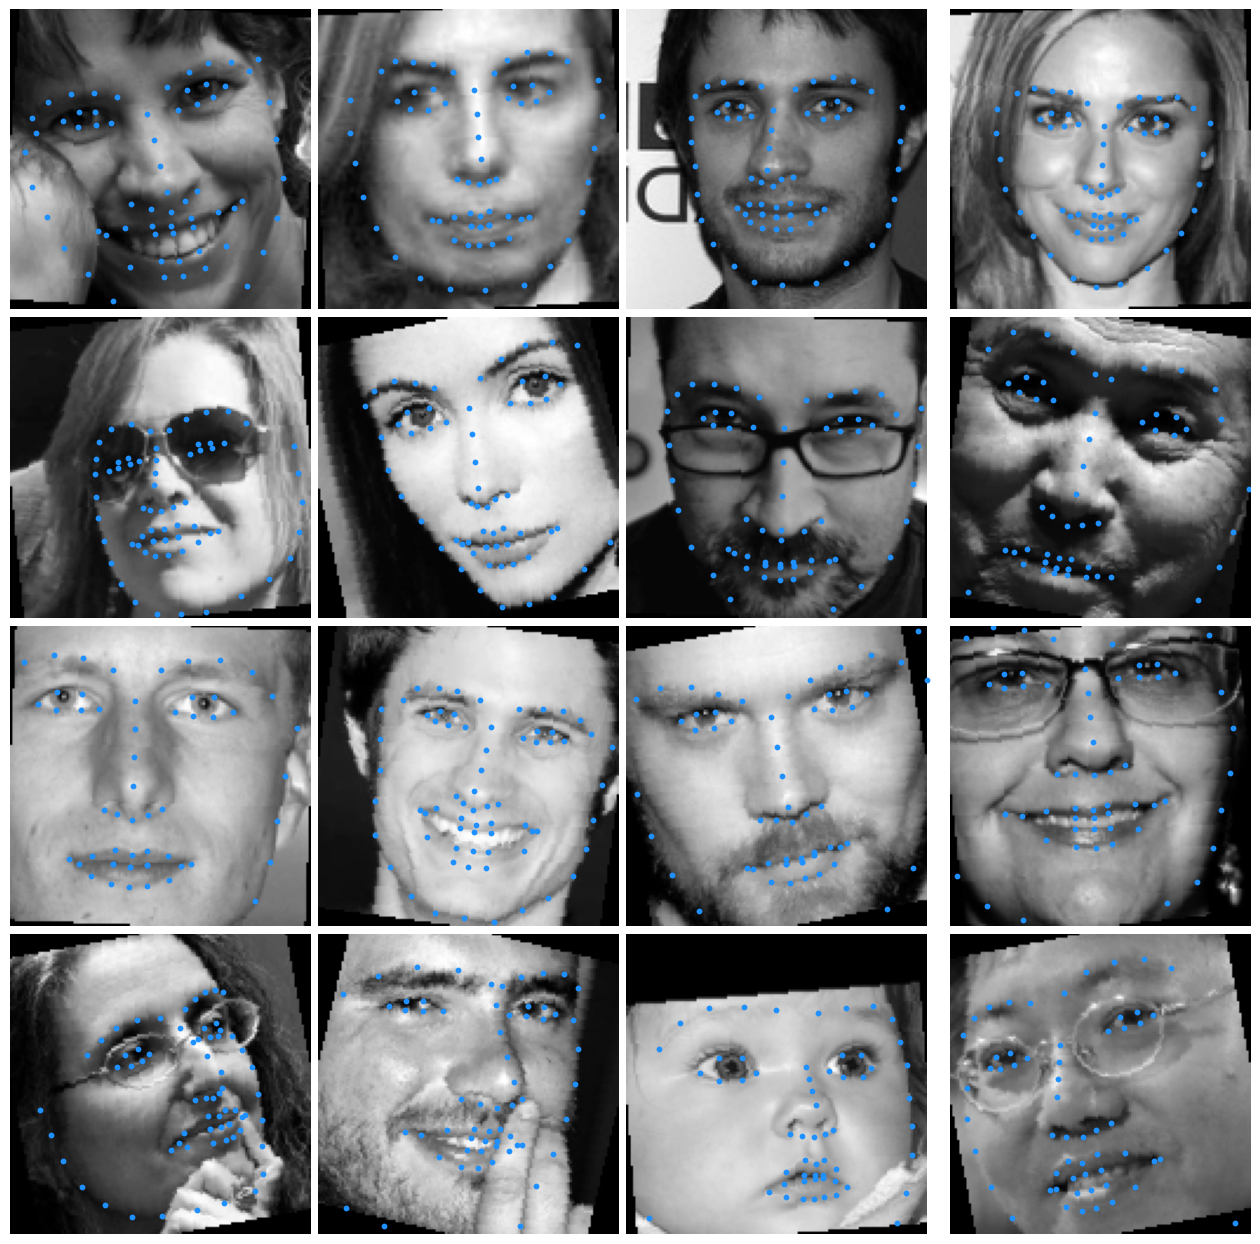

In [9]:
for x,y in train_data:
  break
visiualizebatch(x[:16],y[:16],shape=(4,4),size=16)

#### **XECEPTION NETWORK**
- ENTRY BLOCK
- MIDDLE BLOCK
- EXIT BLOCK

In [11]:
class depthwiseseperableconv2d(nn.Module):
  def __init__(self,input_channels,output_channels,kernel_size,**kwargs):
    super(depthwiseseperableconv2d,self).__init__()


# Depthwise convolution: Applies a separate convolutional filter to each input channel
# 'groups=input_channels' means each channel is convolved independently (depthwise).
    self.depthwise=nn.Conv2d(input_channels,input_channels,kernel_size,groups=input_channels,bias=False,**kwargs)

# Pointwise convolution: Combines the output of the depthwise layer, 
# by applying a 1x1 convolution to reduce or increase the number of channels.

    self.pointwise=nn.Conv2d(input_channels,output_channels,1,bias=False)


  def forward(self,x):
    x=self.depthwise(x)
    x=self.pointwise(x)
    return x

In [12]:
class entryblock(nn.Module):
  def __init__(self):
    super(entryblock,self).__init__()
# First convolution block: 1 input channel to 32 channels, followed by BatchNorm and LeakyReLU
    self.conv1= nn.Sequential(
        nn.Conv2d(1,32,3,padding=1,bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2)
    )
# Second convolution block: 32 input channels to 64 channels
    self.conv2=nn.Sequential(
        nn.Conv2d(32,64,3,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2)
    )
 # Third block (Residual + Direct Path)
    self.conv3_residual=nn.Sequential(
        depthwiseseperableconv2d(64,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(64,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(3,stride=2,padding=1)
    )

# Direct path: 1x1 convolution to match the output of residual (input 64 channels, output 128 channels), and downsample using stride=2

    self.conv3direct=nn.Sequential(
        nn.Conv2d(64,128,1,stride=2),
        nn.BatchNorm2d(128)
    )
# Fourth block (Residual + Direct Path)
    self.conv4_residual=nn.Sequential(
        depthwiseseperableconv2d(128,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(128,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(3,stride=2,padding=1)
    )
# Direct path: 1x1 convolution to match the output of residual (input 128 channels, output 256 channels), and downsample using stride=2
    self.conv4direct=nn.Sequential(
        nn.Conv2d(128,256,1,stride=2),
        nn.BatchNorm2d(256)
    )

# Fifth block (Residual + Direct Path)

    self.conv5_residual=nn.Sequential(
        depthwiseseperableconv2d(256,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(256,728,3,padding=1),
        nn.BatchNorm2d(728),
        nn.MaxPool2d(3,stride=2,padding=1)
    )
    
# Direct path: 1x1 convolution to match the output of residual (input 256 channels, output 728 channels), and downsample using stride=2
    self.conv5direct=nn.Sequential(
        nn.Conv2d(256,728,1,stride=2),
        nn.BatchNorm2d(728)
    )

  def forward(self,x):
    x=self.conv1(x)
    x=self.conv2(x)

    residual=self.conv3_residual(x)
    direct=self.conv3direct(x)
    x=residual+direct

    residual=self.conv4_residual(x)
    direct=self.conv4direct(x)
    x=residual+direct

    residual=self.conv5_residual(x)
    direct=self.conv5direct(x)
    x=residual+direct

    return x

In [13]:
class middleblock(nn.Module):
  def __init__(self):
    super(middleblock,self).__init__()

    self.conv1=nn.Sequential(
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(728,728,3,padding=1),
        nn.BatchNorm2d(728),
    )

    self.conv2=nn.Sequential(
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(728,728,3,padding=1),
        nn.BatchNorm2d(728),
    )
    self.conv3=nn.Sequential(
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(728,728,3,padding=1),
        nn.BatchNorm2d(728),
    )

  def forward(self,x):
    residual=self.conv1(x)
    residual=self.conv2(residual)
    residual=self.conv3(residual)

    return x+residual

In [17]:
class middleiterativeblock(nn.Module):
  def __init__(self,numblocks):
    super(middleiterativeblock,self).__init__()
    
    ''' By using *, you are unpacking the list created by the list comprehension ([middleblock() for _ in range(numblocks)])
    so that each element of the list is passed as an individual argument to nn.Sequential().'''

    self.block=nn.Sequential(*[middleblock() for _ in range(numblocks)])

  def forward(self,x):
    return self.block(x)

In [14]:
class exitblock(nn.Module):
  def __init__(self):
    super(exitblock,self).__init__()

# Residual path: Depthwise separable convolutions followed by BatchNorm, LeakyReLU, and max pooling
    self.residualconv= nn.Sequential(
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(728,728,3,padding=1),
        nn.BatchNorm2d(728),
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(728,1024,3,padding=1),
        nn.BatchNorm2d(1024),
        nn.MaxPool2d(3,stride=2,padding=1)
    )

# Direct path: 1x1 convolution to match the number of channels and downsample (stride=2)
    self.direct=nn.Sequential(
        nn.Conv2d(728,1024,1,stride=2),
        nn.BatchNorm2d(1024)
    )
# Convolution block after residual and direct paths are combined
    self.conv=nn.Sequential(
        depthwiseseperableconv2d(1024,1536,3,padding=1),
        nn.BatchNorm2d(1536),
        nn.LeakyReLU(0.2),
        depthwiseseperableconv2d(1536,2048,3,padding=1),
        nn.BatchNorm2d(2048),
        nn.LeakyReLU(0.2),
    )
# Dropout layer for regularization to prevent overfitting    
    self.dropout =nn.Dropout(0.3)

# Global average pooling to reduce each channel to a single value (1x1 output per channel)    
    self.globlavgpool=nn.AdaptiveAvgPool2d((1,1))


  def forward(self,x):
      direct =self.direct(x)
      residual=self.residualconv(x)
      x=residual+direct
      x=self.conv(x)
      x=self.globlavgpool(x)
      x=self.dropout(x)
      return x

In [15]:
class Network(nn.Module):
  def __init__(self,num_of_blocks):
    super(Network,self).__init__()
# Entry block: Initial layers to extract low-level features
    self.entry_block =entryblock()
# Middle block: A stack of `num_of_blocks` residual blocks (iterative layers) for deep feature extraction
    self.middle_block=middleiterativeblock(num_of_blocks)
# Exit block: Final layers to extract high-level features and reduce spatial dimensions    
    self.exit_block=exitblock()

# Linear layer that outputs 136 values (68 keypoint pairs)

    self.fc=nn.Linear(2048,136)

  def forward(self,x):
    x=self.entry_block(x)
    x=self.middle_block(x)
    x=self.exit_block(x)
    x=x.view(x.size(0),-1)
    x=self.fc(x)

    return x

In [18]:
model=Network(8)
model.cuda()

Network(
  (entry_block): entryblock(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3_residual): Sequential(
      (0): depthwiseseperableconv2d(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): depthwiseseperableconv2d(
        (depthwise

In [19]:
summary(model,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             288
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,432
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]             576
            Conv2d-8         [-1, 64, 128, 128]           4,096
depthwiseseperableconv2d-9         [-1, 64, 128, 128]               0
      BatchNorm2d-10         [-1, 64, 128, 128]             128
        LeakyReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]             576
           Conv2d-13        [-1, 128, 128, 128]           8,192
depthwiseseperableconv2d-14      

#### **DEFINING THE LOSS FUNCTION AND OPTIMIZER**

In [20]:
objective =nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.00075)
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

#### **VALIDATE FUNCTION TO EVALUATE THE PERFORMANCE OF THE MODEL** 

validating:   0%|                                                                                             …

The loss for the epoch 1: 0.06206288425759836


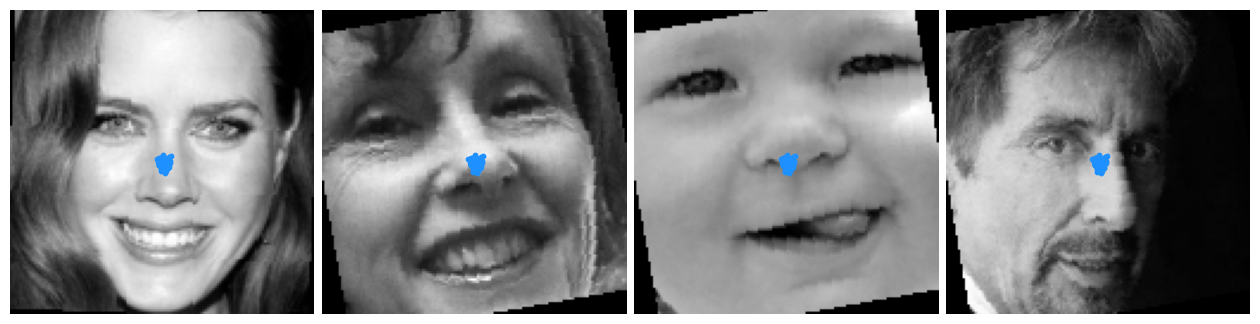

0.06206288425759836

In [21]:
'''The validate function is used to
 evaluate the performance of model on a validation dataset.'''

@torch.no_grad()
def validate(epoch):
  tloss=0.0
  model.eval()

  for feature,labels in tqdm(val_data,desc='validating',ncols=600):
    feature=feature.cuda()
    labels=labels.cuda()

    output=model(feature)
    loss=objective(output,labels)
  
    tloss+=loss.item()
  print(f"The loss for the epoch {epoch}: {tloss/len(val_data)}")
  visiualizebatch(feature[:4].cpu(),output[:4].cpu(),shape=(1,4),size=16)
  return tloss/len(val_data)


validate(epoch=1)

#### **TRAINING THE MODEL**

In [22]:
epochs=30
batches=len(train_data)
updatedloss=np.inf
trainingloss=[]
validationloss=[]

def save_checkpoint(model, optimizer, epoch, path, loss, best=False):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    if best:
        torch.save(state, f'checkpoints/best_model.pt')  # Save the best model
    else:
        torch.save(state, f'checkpoints/checkpoint_everyepoch.pt')  # Save at each epoch

for epoch in range(epochs):
  tloss=0.0
  model.train()
  for feature,labels in tqdm(train_data,desc =f'epoch({epoch+1}/{epochs})',ncols=800):
    feature=feature.cuda()
    labels=labels.cuda()

    output=model(feature)
    loss=objective(output,labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    tloss+=loss.item()

    '''the data goes into the validate() function because the validation dataset (val_data) is already available
    globally or is predefined before training starts. The validate() function uses this dataset directly to perform the validation step.'''
    
  val_loss=validate(epoch) #used to save or log some information during validation.

  save_checkpoint(model, optimizer, epoch + 1, "checkpoints", val_loss)
  if val_loss<updatedloss:
    updatedloss=val_loss
    save_checkpoint(model, optimizer, epoch + 1, "checkpoints", val_loss, best=True)#Saves the model's parameters (weights) to a file named model.pt if the current model has the best validation performance so far.

    '''This allows you to save the model’s progress periodically, which is especially useful if
     you are training for a long time and don’t want to lose progress in case of a system crash.
     By saving the model with the best validation loss,
    you can prevent overfitting by restoring the model from an earlier point before it started overfitting.
    '''
  print(f'epoch({epoch+1}/{epochs}) -> training Loss:{(tloss/batches):.8f} | validation loss:{val_loss:.8f}')
  trainingloss.append(tloss/batches)
  validationloss.append(val_loss)



epoch(1/30):   0%|                                                                                            …

KeyboardInterrupt: 

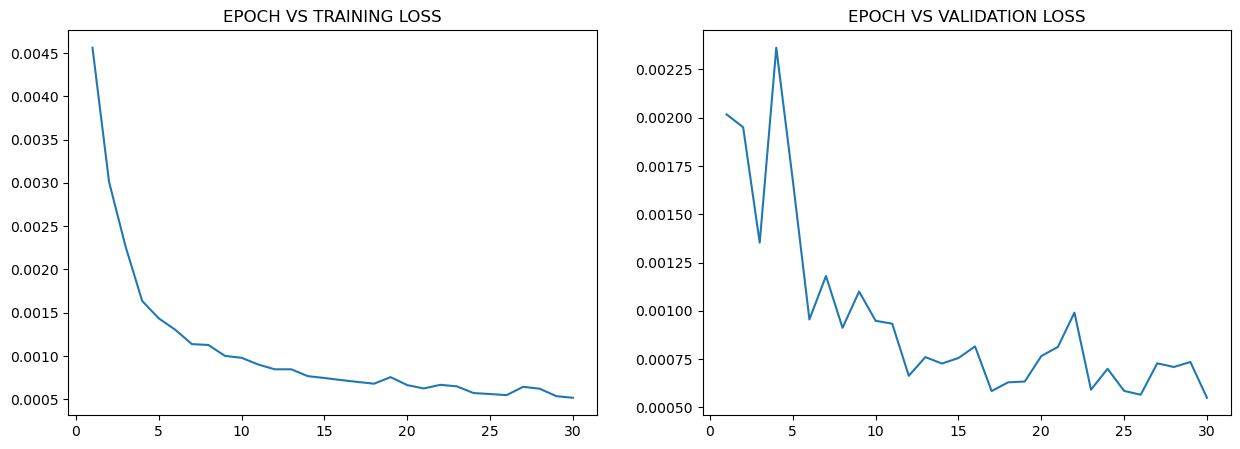

In [52]:

epoch=np.arange(1,31)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch,trainingloss)
plt.title("EPOCH VS TRAINING LOSS")
plt.subplot(1,2,2)
plt.plot(epoch,validationloss)
plt.title("EPOCH VS VALIDATION LOSS")
plt.show()

#### **FUNCTION TO LOAD CHECKPOINTS**

In [23]:
def load_checkpoint(model, optimizer, path, best=False):
    # Choose the best model or the last saved model
    if best:
        checkpoint = torch.load(f'{path}/best_model.pt')  # Load the best model
    else:
        checkpoint = torch.load(f'{path}/checkpoint_everyepoch.pt')  # Load the last saved checkpoint

    # Load model and optimizer states
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # Load the epoch and loss to continue training from the saved point
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"Checkpoint loaded: Resuming from epoch {start_epoch} with loss {loss}")
    
    return model, optimizer, start_epoch, loss


#### **EVALUATING THE MODEL ON THE TESTSET**
-----  INCLUDED FUNCTIONS
- PREPROCESSING
- DRAWING LANDMARKS ON THE ORIGINAL IMAGE
- PREDICTING THE LANDMARKS AND DRAWING
- FINALLY STORING THE IMAGES HAVING PREDICTED LANDMARKS DRAWN ON THEM 



In [24]:
#For the testing the model on the test set
class datasetlandmarkeval(Dataset):
    def __init__(self, rootdir, train):
        self.rootdir = rootdir
        self.imagepath = []
        self.landmarks = []
        self.crops_coordinates = []
        self.train = train

        # Parse the XML file to extract the image paths, landmarks, and crop coordinates
        tree = ET.parse(os.path.join(self.rootdir, f'labels_ibug_300W_{"train" if train else "test"}.xml'))
        root = tree.getroot()

        for child in root[2]:
            self.imagepath.append(os.path.join(self.rootdir, child.attrib['file']))
            self.crops_coordinates.append(child[0].attrib)
            landmark = []
            for i in range(68):
                x_coordinate = int(child[0][i].attrib['x'])
                y_coordinate = int(child[0][i].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

    def __len__(self):
        return len(self.imagepath)

    def __getitem__(self, index):
        # Load the image as a color image (default behavior for skimage.io.imread without as_gray=True)
        image = io.imread(self.imagepath[index], as_gray=False)
        landmarks = self.landmarks[index]
        crops_coordinates = self.crops_coordinates[index]

        # Return the raw image, landmarks, and crop coordinates without any preprocessing
        return image, landmarks, crops_coordinates


In [25]:
#preprocessing the images for the testing of the model
def preprocess(image):
    image=TF.to_pil_image(image)
    image=TF.resize(image,(128,128))
    image=TF.to_tensor(image)
    image=(image-image.min())/(image.max()-image.min())
    image=(2*image)-1
    return image.unsqueeze(0)

In [91]:
#for drawing the predicted landmarks on the original image 
def draw(image,facelandmarks):
    image = np.array(image)
    for landmarks,(left,top,height,width) in facelandmarks:
        landmarks=landmarks.view(-1,2) +0.5
        landmarks =landmarks.numpy()
        for(x,y) in landmarks:
            if np.isnan(x) or np.isnan(y):
                print("NaN value found in landmark coordinates, skipping...")
                continue
            cv2.circle(image,(int((x*width)+left),int((y*height)+top)),4,[229, 245, 10],-1)
        return image

In [72]:
testeval=datasetlandmarkeval(r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\Facial_Landmark_Detection_project\archive (1)\ibug_300W_large_face_landmark_dataset',False)
testeval_data=DataLoader(testeval,batch_size=1,shuffle=False)





In [73]:
#predicting and drawing the landmarks on the images
def predictions(image, cropcordinates):
    x, y, w, h = cropcordinates['left'], cropcordinates['top'], cropcordinates['width'], cropcordinates['height']

    

    # Ensure these values are integers
    x, y, w, h = int(x), int(y), int(w), int(h)
    image=TF.to_pil_image(image)
    gray=TF.to_grayscale(image)
    gray = np.array(gray)
    crop = gray[y:y+h, x:x+w]
    
    output = []
    preproimage = preprocess(crop)
    

    predicted=model(preproimage.cuda())
    output.append((predicted.cpu(),(x,y,h,w)))
    return draw(image,output)   



In [92]:
#testing loop which will iterate on the each images and stored the output in the list after drawing the landmarks
model=Network(8)
model.cuda()
optimizer=optim.Adam(model.parameters(),lr=0.00075)

#LOADING THE CHECKPOINTS
model, optimizer, start_epoch, updatedloss = load_checkpoint(model, optimizer, "checkpoints", best=True)
@torch.no_grad()
def validatetest():
  outputs=[]
  model.eval()

  for image,landmarks,cropcordinates in tqdm(testeval,desc='validating',ncols=600):
    output=predictions(image,cropcordinates)
    
    outputs.append(output)
  
   
  
 
  return outputs
    

C:\Users\soham\AppData\Local\Temp\ipykernel_20900\514780093.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{path}/best_model.pt')  # Load the 

Checkpoint loaded: Resuming from epoch 30 with loss 0.0005496493778826499


In [93]:
output=validatetest()

validating:   0%|                                                                                             …

x: 70, y: 224, w: 295, h: 295
x: 491, y: 475, w: 151, h: 150
x: 133, y: 64, w: 125, h: 125
x: 279, y: 328, w: 446, h: 447
x: 427, y: 328, w: 447, h: 447
x: 228, y: 228, w: 310, h: 310
x: 356, y: 273, w: 373, h: 373
x: 1565, y: 749, w: 180, h: 180
x: 940, y: 940, w: 1110, h: 1110
x: 1605, y: 1685, w: 180, h: 180
x: 161, y: 133, w: 259, h: 259
x: 273, y: 232, w: 373, h: 373
x: 680, y: 886, w: 926, h: 925
x: 22, y: 9, w: 126, h: 125
x: 572, y: 513, w: 536, h: 536
x: -68, y: 229, w: 496, h: 447
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark coordinates, skipping...
NaN value found in landmark

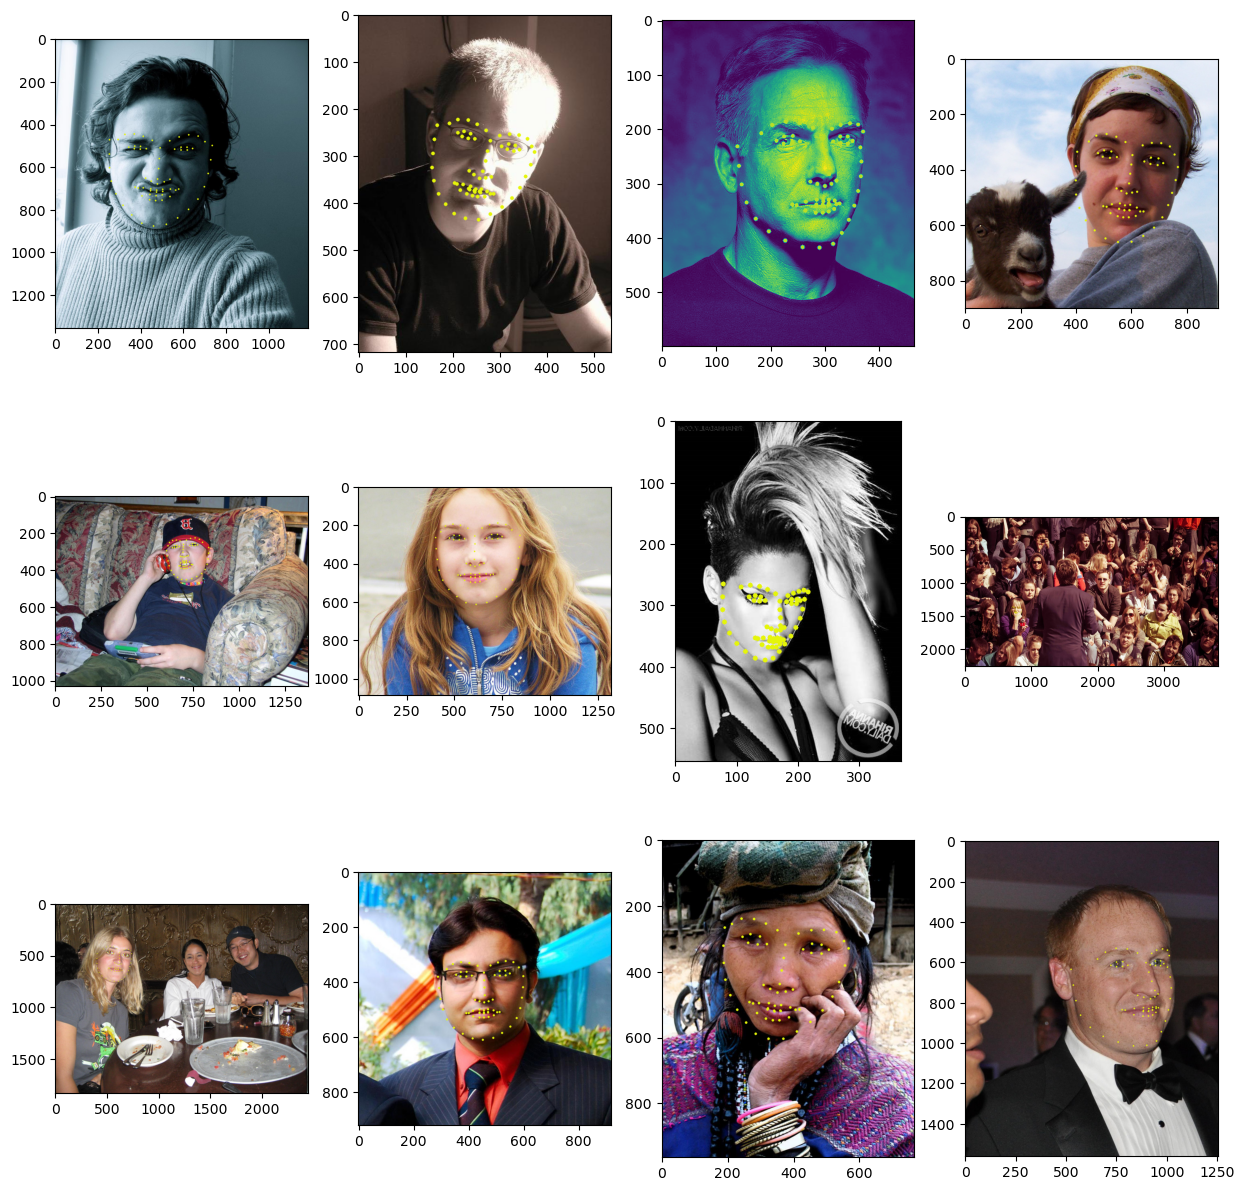

In [94]:
plt.figure(figsize=(15,15))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.imshow(output[800+i])
    

plt.show()